## Simulation of the Heston model using the Quadratic exponential scheme

In order to achieve maximum performance of Pytorch in a Monte-Carlo simulation it is critical to vectorize over the number of simulations. Thus we need to remove all 'if' statements from the Quadratic Exponential scheme.

In [157]:
import torch
import numpy as np
from quant_analytics_torch.analytics import blackanalytics
from icecream import ic

In [176]:
paths =2**12-1
n_dt = 32
paths

4095

In [177]:
rho = torch.tensor(-0.7829, requires_grad=True)
v0 = torch.tensor((0.2556)**2, requires_grad=True)
theta = torch.tensor((0.3095)**2, requires_grad=True)
kappa = torch.tensor(3.8, requires_grad=True)
eta= torch.tensor(0.9288, requires_grad=True)
T = 0.5
dt = T/n_dt
dim = n_dt

In [178]:
gamma1 = 0.5
gamma2 = 0.5

K0 = -(rho*kappa*theta)*dt/eta
K1 = gamma1*dt*(-0.5+(kappa*rho/eta))-(rho/eta)
K2 = gamma2*dt*(-0.5+(kappa*rho/eta))+(rho/eta)
K3 = gamma1*dt*(1-rho**2)
K4 = gamma2*dt*(1-rho**2)

ic(K3)
ic(K4)


ic| K3: tensor(0.0030, grad_fn=<MulBackward0>)
ic| K4: tensor(0.0030, grad_fn=<MulBackward0>)


tensor(0.0030, grad_fn=<MulBackward0>)

In [179]:
X = torch.zeros([paths])
#V = torch.zeros([n_dt+1,paths])
Vt = torch.zeros([paths])
Vt[:] = theta
#V[0] = theta

In [180]:
sobol_engine =  torch.quasirandom.SobolEngine(2*dim)
# x = sobol_engine.draw(1 + (2**14-1) + (2**12-1) + (2**8-1) + (2**7-1) + (2**5-1) + (2**4-1))
x = sobol_engine.draw(1)

In [181]:
u = sobol_engine.draw(paths,dtype=torch.float64)

In [182]:
u = torch.transpose(u,0,1)
# Random variable for the underlying
u1 = u[:dim]
# Random variables for the volatility
u2 = u[dim:]

In [183]:
from quant_analytics_torch.calculators.multivariatebrownianbridge import MultivariateBrownianBridge
from quant_analytics_torch.analytics.norminv import norminv

In [184]:
states = 1
dim = n_dt

fm = torch.zeros(size=(states,states))

fm[0][0] = 1.
fwd_cov = torch.zeros(size=(dim, states, states))

for i in range(dim):
    fwd_cov[i] = fm

In [185]:
multivariate_brownian = MultivariateBrownianBridge(fwd_cov)

In [186]:
y = norminv(u1)
y = torch.reshape(y, shape=(dim,states,paths))

In [187]:
dz = multivariate_brownian.path(y, True)
dz[1][0]

tensor([ 0.0000, -0.0698,  0.0698,  ..., -0.2891,  0.3030,  0.7536])

In [188]:
from quant_analytics_torch.analytics import maxsoft
from quant_analytics_torch.analytics.characteristicfunction import heston_option_price


In [189]:
import matplotlib
from matplotlib import pyplot as plt

In [190]:
for i in range(n_dt):
    Vold = Vt
    minusexpkappadt = torch.exp(-kappa*dt)
    m = theta+( Vt - theta) * minusexpkappadt
    s2 = ((Vt*eta**2) * minusexpkappadt/kappa)*(1-minusexpkappadt) + ( theta*eta**2)*((1-minusexpkappadt)**2)/(2*kappa)
    phi = s2/m**2
    #
    # Calculate the lower branch
    #
    b2 = torch.maximum((2/phi)-1+2*(torch.sqrt(2/phi))*(torch.sqrt(torch.maximum(-1+2/phi, torch.tensor(0.)))),torch.tensor(0.))
    a = m/(1+b2)
    z2 = norminv(u2[i])
    Vnew_1 = a*(z2 + b2**0.5)**2
    #
    # Calulcate the upper branch
    #
    p = (phi-1)/(phi+1)
    beta = 2/(m+m*phi)
    Vnew_2 = torch.log((1-p)/(1-u2[i])) / beta
    Vnew_2 = torch.maximum(Vnew_2, torch.tensor(0.))
    phiC = 1.5
    #
    # Switch the branches
    #
    p_1 = maxsoft.soft_heavy_side_hyperbolic(phiC-phi, 0.0001)
    q_1 = 1. - p_1
    Vt = p_1 * Vnew_1 + q_1 * Vnew_2
    # V[i+1] = Vt
    #
    # Update the underlying
    #
    # z1 = norminv(u1[i])   
    z1 = dz[i][0]
    X = X + K0 + K1*Vold + K2*Vt + (torch.sqrt(K3*Vold+K4*Vt))*z1


In [191]:
S = torch.exp(X)
Savg = torch.mean(S)
Pavg = torch.mean(torch.maximum(S-1.,torch.tensor(0.)))
print(Savg)
print(Pavg)

tensor(0.9967, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0707, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [192]:
nk = 21
k = np.linspace(0.7,1.3,nk)
iv = torch.zeros(nk)
ivh = torch.zeros(nk)

for it,ik in enumerate(k):
    p = torch.mean(torch.maximum(S-ik,torch.tensor(0.))).detach().numpy()
    iv[it] = blackanalytics.impliedvolatility(p, 1., ik, T)

    ph = heston_option_price(ik, 1., theta.detach().numpy(), kappa.detach().numpy(), theta.detach().numpy(), eta.detach().numpy(), rho.detach().numpy(), T)
    ivh[it] = blackanalytics.impliedvolatility(ph, 1., ik, T)



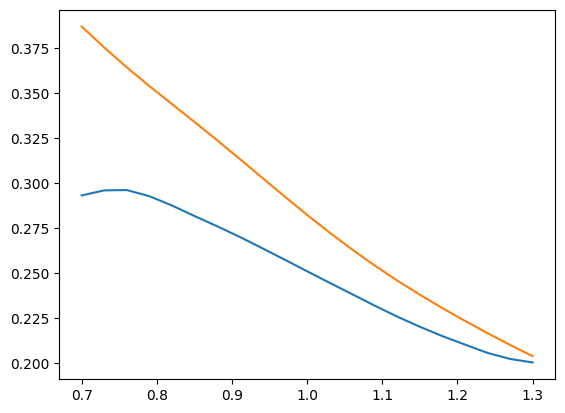

In [193]:
plt.plot(k,iv)
plt.plot(k,ivh)

In [9]:
#plt.plot(V.detach().numpy()[:,:10])

In [272]:
x = -7.7721

In [274]:
maxsoft.soft_heavy_side_hyperbolic(torch.tensor(x))

tensor(0.)